This notebook provides detailed instructions on how to apply the NSGA-II algorithm to design near-optimal sidewalk solutions for various study areas. The algorithm aims to optimize changes in walking perceptions before and after intervention, across 12 mutually exclusive social groups. The dataset used in this study was collected through online, individual-level surveys that capture people’s perceptions of safety, comfort, and willingness to walk in the existing travel environment.

Because the dataset involves human-subject data protected by IRB protocols, sharing it could compromise participant privacy. To prevent any potential violations, we have chosen not to include the original dataset in this documentation. However, to effectively demonstrate how the code works, we have created a mock dataset and used it to illustrate code functionality and visualization examples.

In [1]:
# required libraries
import sys
import pandas as pd
import geopandas as gpd
import numpy as np
import ast
import numpy as np, numpy.random


%matplotlib inline
import matplotlib.pyplot as plt


import networkx as nx
import joblib
plt.style.use('seaborn-whitegrid')
import time
import seaborn as sns

C:\Users\armit\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\armit\AppData\Local\Temp\ipykernel_4628\2240649260.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Data

The multi-objective optimization focuses on the before-and-after changes in walking perception scores across 12 mutually exclusive socio-economic groups, categorized by gender, income, and race. The algorithm uses the following key datasets:

1. sidewalk_gap_hilltop_mock_dat.csv: This dataset includes changes in walking perception scores for the 12 socio-economic groups across all road segments with sidewalk gaps in the study area. For demonstration purposes, we provide mock walking perception data for the Hilltop area only.

    - Column names ending with _old represent the perception scores before sidewalk construction.

    - Column names ending with _after represent the perception scores after sidewalk construction.

2. Hilltop_nearest_rd.pkl: This file contains the nearest road segment IDs for each vertex along the road network. It captures the network topology and is essential for enforcing partial connectivity constraints in the network design. 

3. Hilltop_nearest_rd_no_geom.pkl: This is a simplified version of the previous dataset, excluding point geometry for the road vertices. While the version with geometry is useful for understanding the structure of the network, this no-geometry version is primarily used for faster computation during model execution.

4. Franklin_street_centerline_MOPRC and Area_commissions: These shapefiles are used for visualization purposes, allowing us to display street centerlines within the study area when illustrating the network design solutions. 

Please note that only the walking perception data has been mocked for demonstration; all other datasets used in this notebook are real.

In [2]:
# list of 12 social groups
grp = ['male_high_white', 'female_high_white', 
       'male_high_poc', 'female_high_poc', 
       'male_med_white', 'female_med_white', 
       'male_med_poc', 'female_med_poc', 
       'male_low_white', 'female_low_white',
       'male_low_poc', 'female_low_poc']

In [9]:
# road dataset with no sidewalk and group-specific perception scores
gap1 = pd.read_csv(r'Data\sidewalk_gap_hilltop_mock_dat.csv')
gap1

,OBJECTID,male_high_white_old,male_med_white_old,male_low_white_old,female_high_white_old,female_med_white_old,female_low_white_old,male_high_poc_old,male_med_poc_old,male_low_poc_old,...,male_low_white_new,female_high_white_new,female_med_white_new,female_low_white_new,male_high_poc_new,male_med_poc_new,male_low_poc_new,female_high_poc_new,female_med_poc_new,female_low_poc_new
0,41138,2.861073,2.429572,2.149481,2.842321,2.536292,2.777635,2.391999,1.851273,1.844375,...,3.802561,3.944821,3.892264,3.761210,3.928626,3.939947,3.668688,3.895734,3.857272,3.660342
1,41197,2.705632,2.279354,1.991735,2.694352,2.399550,2.644301,2.231430,1.695654,1.687720,...,4.052423,4.219222,4.161836,4.022174,4.192974,4.193444,3.918061,4.170797,4.127180,3.923959
2,41224,2.931662,2.500388,2.219951,2.913250,2.607724,2.849232,2.462345,1.921830,1.914890,...,3.893543,4.037200,3.984347,3.852724,4.020436,4.031211,3.759465,3.988021,3.949243,3.751807
3,41353,2.787778,2.358054,2.075311,2.771626,2.469478,2.712049,2.316873,1.777805,1.770561,...,3.889512,4.039937,3.985850,3.851756,4.020449,4.028310,3.755270,3.991051,3.950979,3.751645
4,41415,1.832145,1.750185,1.651944,1.726312,1.756285,2.164715,1.609985,1.494051,1.583777,...,3.623766,3.606870,3.646739,3.430835,3.970484,4.205110,3.807980,3.737479,3.863188,3.576791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1388,104731,2.861337,2.452343,2.176366,2.847168,2.562672,2.778950,2.399664,1.870425,1.842396,...,4.011664,4.135516,4.080676,3.974045,4.100364,4.099793,3.867539,4.077171,4.029038,3.865307
1389,104732,2.923912,2.491647,2.212737,2.904011,2.596286,2.837073,2.455661,1.914234,1.907482,...,3.855407,3.993530,3.941792,3.812407,3.979003,3.991949,3.722040,3.944580,3.906984,3.711525
1390,104735,2.637280,2.205682,1.925739,2.618385,2.312144,2.553419,2.168307,1.627492,1.620614,...,4.048586,4.190525,4.138013,4.007070,4.174455,4.185920,3.914692,4.141389,4.102971,3.906120
1391,104899,2.635813,2.202570,1.923486,2.615431,2.306398,2.546090,2.168258,1.625675,1.618443,...,3.839623,3.984743,3.931118,3.799944,3.966914,3.976845,3.704362,3.934699,3.894895,3.697261


In [13]:
# network topology
nearest_dat = pd.read_pickle(r'Data\Hilltop_nearest_rd.pkl')
nearest_dat

C:\ProgramData\anaconda3\Lib\pickle.py:1718: UserWarning: Unpickling a shapely <2.0 geometry object. Please save the pickle again; shapely 2.1 will not have this compatibility.
  setstate(state)


,OBJECTID,geometry,nearest
3,41138,POINT (-9252392.670 4858128.679),"[41224, 41353]"
4,41138,POINT (-9252437.282 4858164.724),"[41224, 41353]"
5,41197,POINT (-9245355.928 4857041.999),[70898]
6,41197,POINT (-9245235.028 4857117.084),"[41879, 55340]"
7,41224,POINT (-9252392.670 4858128.679),"[41138, 41353]"
...,...,...,...
6227,106247,POINT (-9248037.808 4854936.356),"[78580, 85863]"
6228,106250,POINT (-9247812.420 4854858.340),[106238]
6229,106250,POINT (-9247244.250 4854681.110),[70234]
6230,106338,POINT (-9251629.434 4856839.969),"[70548, 72787]"


In [14]:
# combining them by road IDs
nearest_dat = nearest_dat[['OBJECTID', 'nearest']]
nn = nearest_dat.groupby(['OBJECTID'],sort=False).sum().reset_index()

In [4]:
# road and area shapefiles
road = gpd.read_file(r'Data\Franklin_street_centerline_MORPC\Franklin_street_centerline_MORPC.shp')
road['Fclass'] = [int(road['Fclass'].iloc[i])  if road['Fclass'].iloc[i] != None else 0 for i in range(len(road))]
road = road[(road['Fclass'] >2) & (road['Fclass'] < 8)]

area = gpd.read_file(r'Data\Area_Commissions\Area_Commissions.shp')
sa = area[(area.AREA_NAME == 'Greater Hilltop Area Commission') ]
sa_rd = gpd.sjoin(road, sa, op='intersects')
sa_rd['sidewalk_b'] = ['N' if sa_rd.SIDEWALK.iloc[i] == 'N' else 'Y' for i in range(len(sa_rd))]
sa_rd['OBJECTID'] = sa_rd['OBJECTID_left']

Cannot find header.dxf (GDAL_DATA is not defined)
PROJ: proj_create_from_database: Cannot find proj.db
C:\ProgramData\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3466: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


#  Code implementation

The code compiles various steps of NSGA-II in multiple .py files. 

- basic_GA.py: This file contains all the fundamental functions of the genetic algorithm, such as calculating objective functions, tournament selection, crossover, mutation, and computing the length of each network solution. 

- connectivity.py: This file includes all functions related to evaluating network connectivity, such as identifying and counting the number of gap or no-gap road for any solution road and estimate connectivity ratio for each network solution.  

- initialization.py: This file contains the function that randomly initializes the first population set without conforming to the length critria. Note that the crowding value we calculate here is actually a crowd-coninuous index - crowding distance multipled by continuity ratio. The file also contain another function that creates naive network solution only based on the length criteria, but does not go through further fitness evaluaion or regeneration process.  

- repair.py: This file provides a function to modify network solutions so they meet the length constraint, while prioritizing connectivity within the network. 

- NSGA.py: This file implements key functions of the NSGA-II algorithm, including non-dominated sorting, rank assignment, crowding distance calculation, and fast Pareto front computation.

- generation.py: This file generates the next population by applying tournament selection based on the previous generation's fitness, followed by crossover and mutation operations.



To execute the algorithm, the user needs to run the following .py files in sequence:

- parameter_selection_part1.py: This script generates network solutions for all specified parameter combinations. 

- parameter_selection_part2.py: This script sorts the generated solutions based on each parameter combination (e.g., different population sizes) and calculates their non-domination ranks. This helps identify which parameter values yield the highest number of non-dominated solutions and therefore should be used in the final modeling process. The results are further visualized using R—see the accompanying .Rmd file for details. 

- model_run_part1.py: This script generates network solutions using the optimal parameter values identified during the parameter selection process.

- model_run_part2.py: This script sorts and ranks the final set of solutions, and also generates a naive solution for the specific study area. Additional visualizations are provided in the .Rmd file.

## Plot extreme solutions

Please note that these results are generated using mock data and therefore do not resemble to our actual findings. 

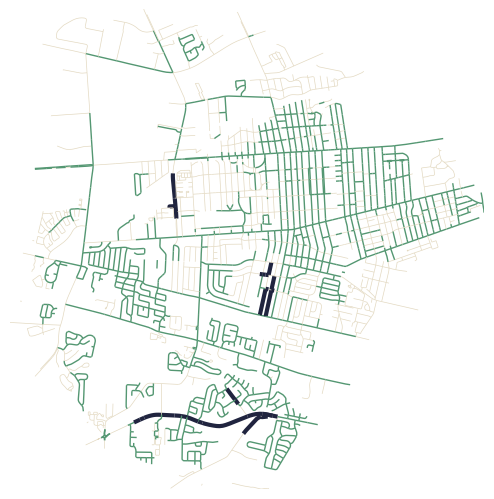

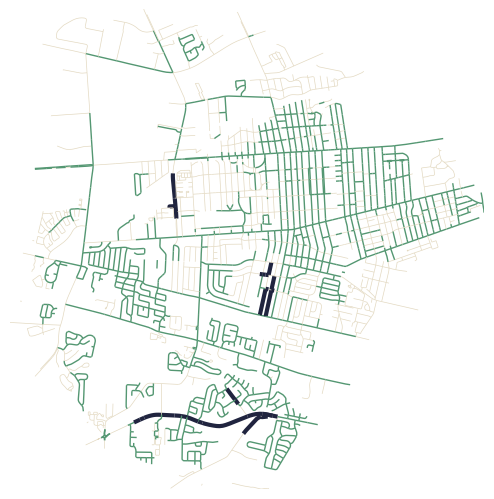

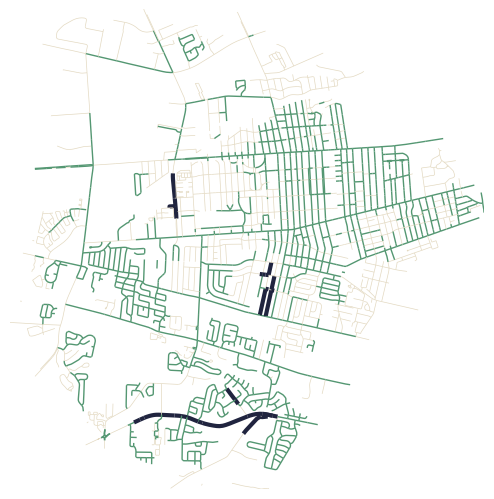

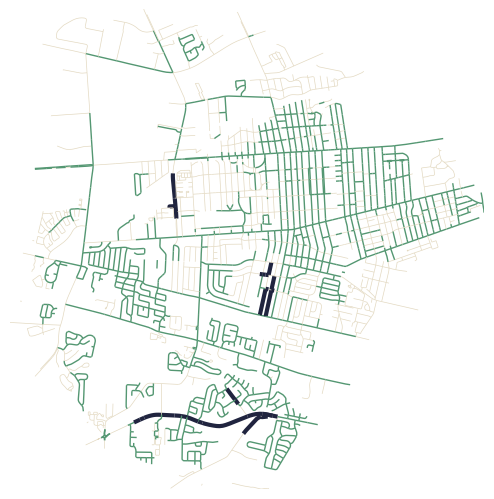

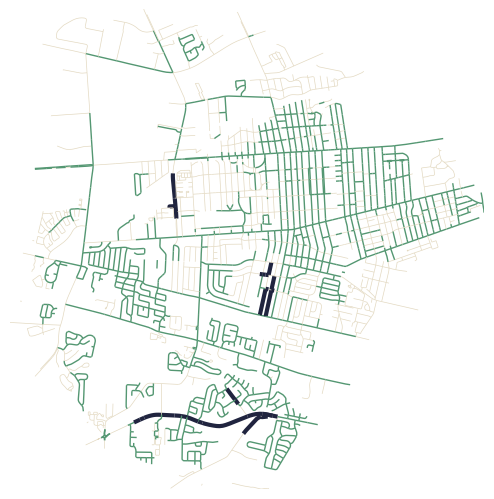

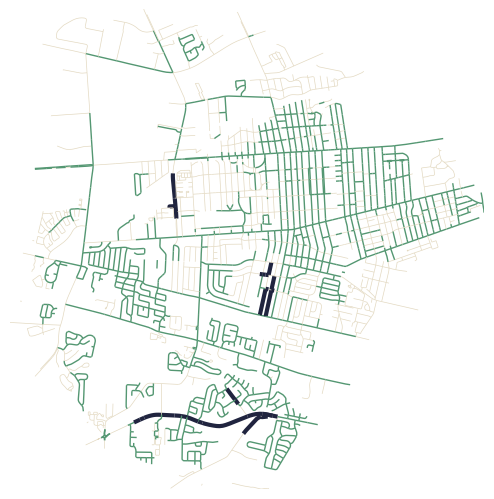

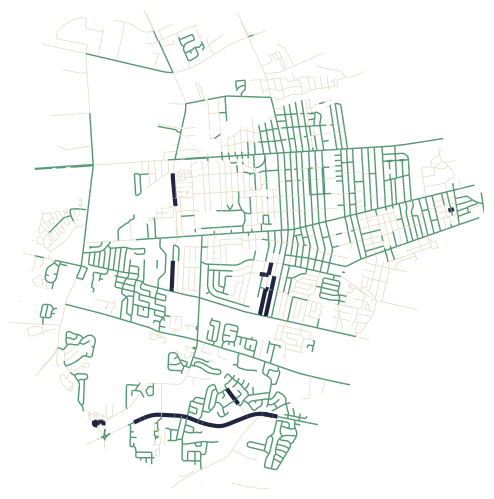

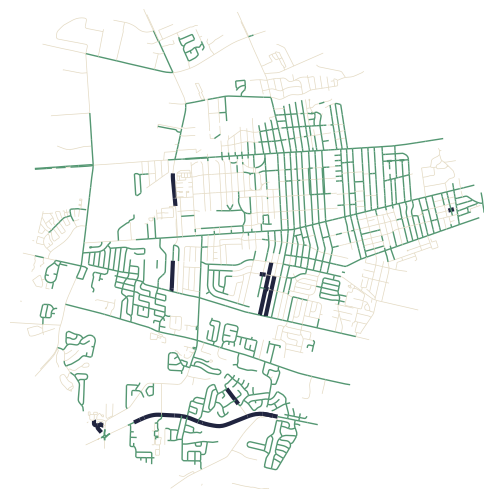

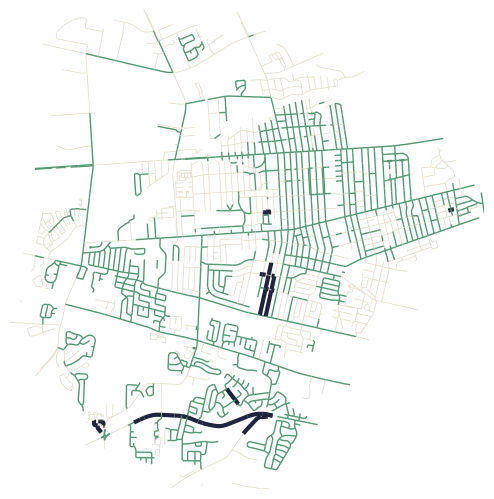

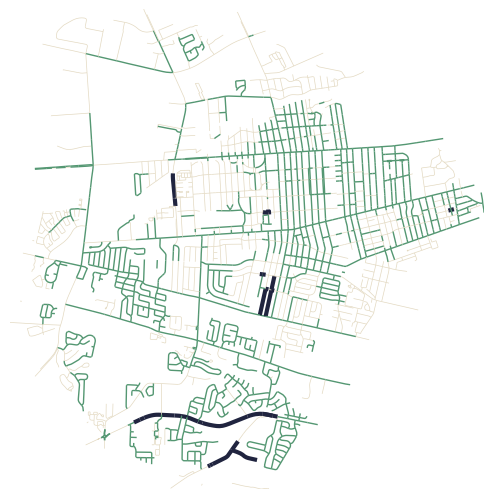

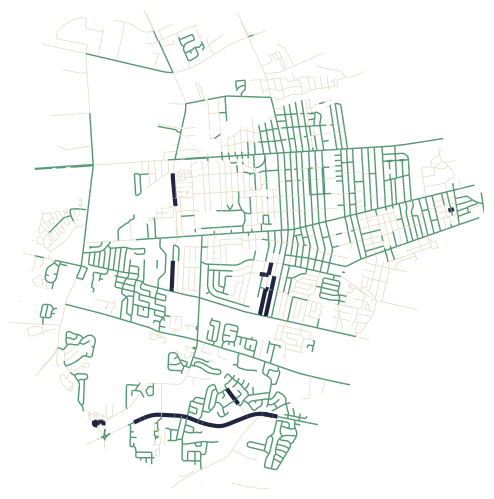

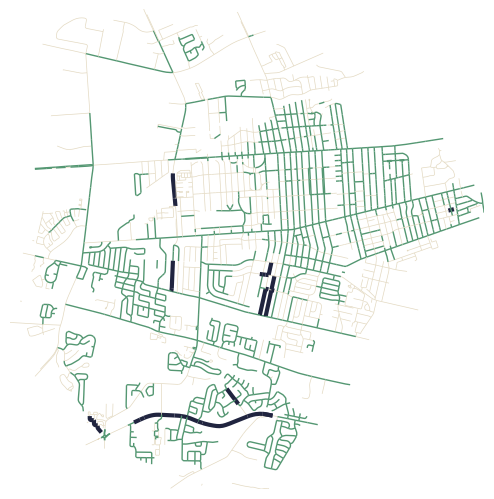

In [8]:
#### plot extreme/optimal solutions
area = "hilltop"
dat = pd.read_csv(r'Output\%s_final solutions_sorted.csv'%area)

for i in grp:
    dat1 = dat[dat['sol_type'] == 'Extreme (%s)'%i]
    
    gap1['sol']  = ast.literal_eval(dat1['sols'].iloc[0])
    #gap1['sol']  = dat1['sols'].iloc[i]
    gap1['sol'].unique()
    ab = gap1[['OBJECTID', 'sol']]

    sa_rd1 = pd.merge(sa_rd, ab, on= 'OBJECTID', how = 'outer')
    sa_rd1['sol'] = sa_rd1['sol'].fillna('Existing sidewalks')
    sa_rd1['sol'] = sa_rd1['sol'].replace(1,'New sidewalks')
    sa_rd1['sol'] = sa_rd1['sol'].replace(0.0,' No sidewalk')
    sa_rd1['sol1'] = [3.0 if sa_rd1['sol'].iloc[i] == 'New sidewalks' else 1.0 if sa_rd1['sol'].iloc[i] == 'Existing sidewalks' 
                      else 0.5 for i in range(len(sa_rd1))]
    
    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    sa_rd1.plot('sol', ax = ax,
                legend=False, cmap=sns.cubehelix_palette(start=.25, rot=-.75, as_cmap=True), 
                figsize=(5,8), 
                #legend_kwds={'loc': 'lower right', 'fontsize': 15}, 
                linewidth = sa_rd1['sol1']).set_axis_off()
    ax.margins(0)
    ax.apply_aspect()
    bbox = ax.get_window_extent().transformed(fig.transFigure.inverted())
    w,h = fig.get_size_inches()
    fig.set_size_inches(w*bbox.width, h*bbox.height)

    #plt.savefig('sample.png')
    plt.savefig(r'Output\Images\%s_extreme_%s.png'%(area, i), dpi=100)
    

# Plot naive solutions

Please note that these results are generated using mock data and therefore do not resemble to our actual findings. 

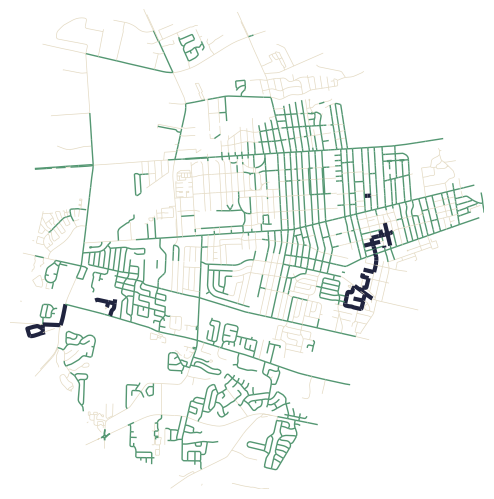

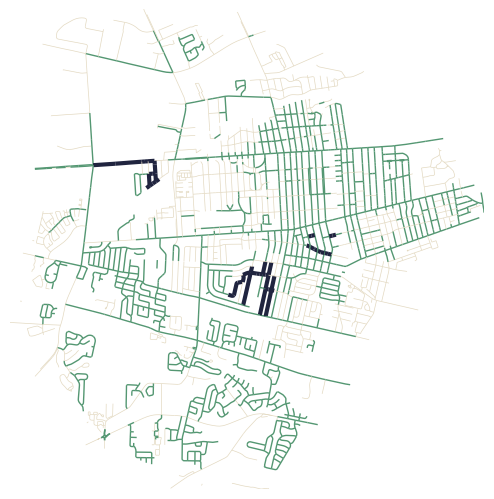

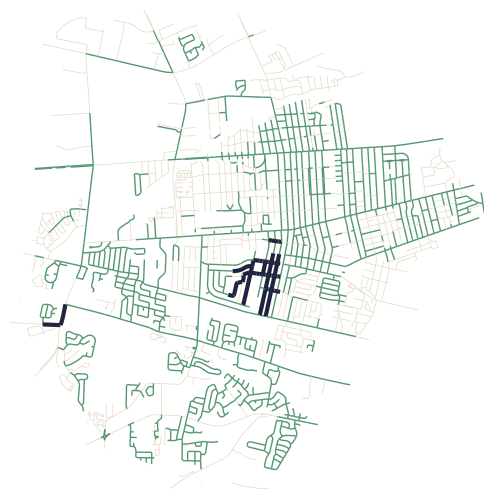

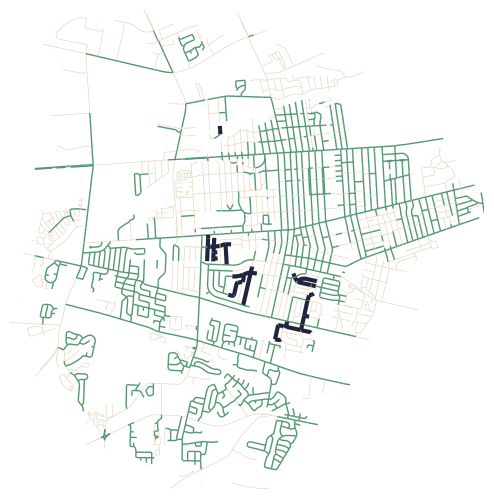

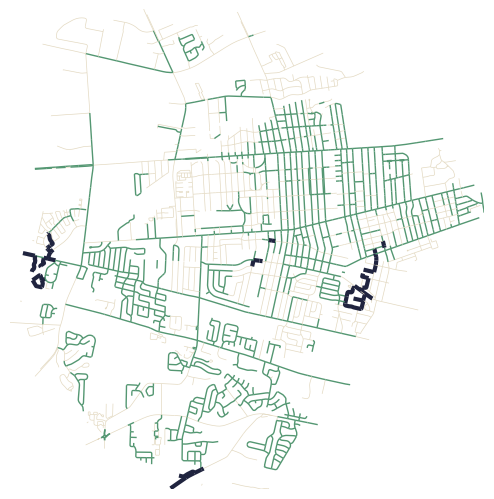

In [7]:
#### plot naive solutions
area = "hilltop"
dat = pd.read_csv(r'Output\%s_naive_solution.csv'%area)

for i in range(len(dat)):
    gap1['sol']  = ast.literal_eval(dat['sols'].iloc[i])
    gap1['sol'].unique()
    ab = gap1[['OBJECTID', 'sol']]

    sa_rd1 = pd.merge(sa_rd, ab, on= 'OBJECTID', how = 'outer')
    sa_rd1['sol'] = sa_rd1['sol'].fillna('Existing sidewalks')
    sa_rd1['sol'] = sa_rd1['sol'].replace(1,'New sidewalks')
    sa_rd1['sol'] = sa_rd1['sol'].replace(0.0,' No sidewalk')
    sa_rd1['sol1'] = [3.0 if sa_rd1['sol'].iloc[i] == 'New sidewalks' else 1.0 if sa_rd1['sol'].iloc[i] == 'Existing sidewalks' 
                      else 0.5 for i in range(len(sa_rd1))]

    fig = plt.figure()
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')

    sa_rd1.plot('sol', ax = ax,
                legend=False, cmap=sns.cubehelix_palette(start=.25, rot=-.75, as_cmap=True), 
                figsize=(5,8), 
                #legend_kwds={'loc': 'lower right', 'fontsize': 15}, 
                linewidth = sa_rd1['sol1']).set_axis_off()
    ax.margins(0)
    ax.apply_aspect()
    bbox = ax.get_window_extent().transformed(fig.transFigure.inverted())
    w,h = fig.get_size_inches()
    fig.set_size_inches(w*bbox.width, h*bbox.height)
    
    plt.savefig(r'Output\Images\%s_naive_%s.png'%(area, i), dpi=500)